# Detect hate and toxicity in online comments.
### by CS21S048

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import log_loss

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack


In [ ]:
#NLP tools
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
%matplotlib inline
#Plot and image tools
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns


In [ ]:
#Loading the Data
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip').fillna(' ')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip').fillna(' ')


In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


In [ ]:
def train_test_split(df, frac=0.2):

    # get random sample
    test = df.sample(frac=frac, axis=0)

    # get everything but the test sample
    train = df.drop(index=test.index)

    return train, test

train, test=train_test_split(train)

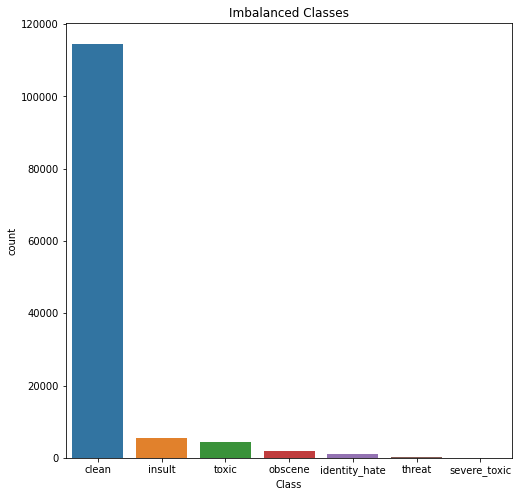

In [ ]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['Class']='clean'
for i in range(1,7):
    train.loc[train[class_names[i-1]]==1,'Class']=class_names[i-1]
plt.figure(figsize=(8, 8))
sns.countplot(x='Class', data=train)
plt.title('Imbalanced Classes')
plt.show()



In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import TweetTokenizer
tokenizer=TweetTokenizer()
from nltk.stem import PorterStemmer
import emoji
porter = PorterStemmer()
def cleaner(tweet):
    tweet = tweet.lower()#Convert to lower case
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet=  re.sub('\W+',' ', tweet)#remove special characters
    tweet= re.sub(r'\b\d+(?:\.\d+)?\s+', '', tweet)#remove numbers
    tweet = " ".join(tweet.split())#remove white space
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w.lower() not in stopwords or not w.isalpha())#remove stop words

    #tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w.lower() in words.words() or not w.isalpha())
    return tweet
#train['processed']=train['comment_text']
#create a new column in the pandas dataframe
train['processed'] = train['comment_text'].apply(lambda x: cleaner(x))

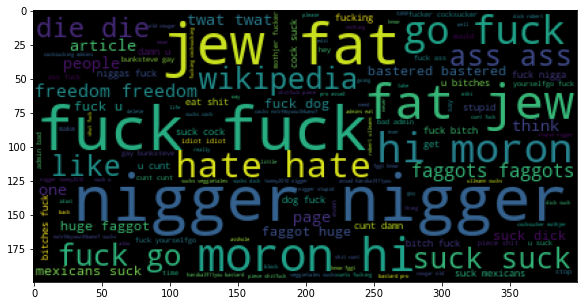

In [ ]:
def wordcloud_plot(category) :
    plt.figure(figsize=(10,5))
    wc = WordCloud(stopwords=stopwords)
    wc.generate(" ".join(category))
    plt.imshow(wc)
wordcloud_plot(train[train['insult']==1]['processed'])

In [ ]:
#Train a tf-idf feature extarctor
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer = 'word',ngram_range=(1,1),max_features=1000)#selector top 1000 important feature
#ngram - select one word range to classify
vectoriser_model = vectorizer.fit(train['processed'].values.astype('U').tolist())
print(vectorizer.get_feature_names_out()[:100])#print the 1000 selected words

['able' 'absolutely' 'abuse' 'accept' 'acceptable' 'accepted' 'access'
 'according' 'account' 'accounts' 'accurate' 'across' 'act' 'action'
 'actions' 'actual' 'actually' 'add' 'added' 'adding' 'addition' 'address'
 'admin' 'administrator' 'administrators' 'admins' 'advice' 'afd' 'age'
 'ago' 'agree' 'ahead' 'aids' 'al' 'album' 'align' 'allow' 'allowed'
 'almost' 'alone' 'along' 'already' 'also' 'although' 'always' 'america'
 'american' 'among' 'amount' 'anonymous' 'another' 'answer' 'anti'
 'anyone' 'anything' 'anyway' 'apparently' 'appear' 'appears' 'appreciate'
 'appropriate' 'april' 'archive' 'area' 'argument' 'arguments' 'around'
 'article' 'articles' 'ask' 'asked' 'asking' 'ass' 'asshole' 'assume'
 'attack' 'attacks' 'attempt' 'attention' 'august' 'author'
 'automatically' 'available' 'avoid' 'aware' 'away' 'back' 'background'
 'bad' 'balls' 'ban' 'band' 'banned' 'bark' 'barnstar' 'based' 'basic'
 'basis' 'become' 'behavior']


In [ ]:
def fit(clf):
    class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    model_score=[]
    for class_toxicity in class_names:
        # Put all the fraud class in a separate dataset.
        df = train.loc[train[class_toxicity] == 1]
        #Randomly select {df.shape[0]} observations from the majority class
        ndf = train.loc[train[class_toxicity] == 0].sample(n=df.shape[0],random_state=42)
        #Join the two class of dataset
        normalized_df = pd.concat([df, ndf])
        #Shuffle our dataset
        normalized_df=normalized_df.sample(frac=1,random_state=4)
        #Create tf-idf feature vector for our dataset
        features=vectoriser_model.transform(normalized_df["processed"])
        #K-fold cross validation- We are training fro on vs rest cv--- 10 means ten fold cross validation
        scores=cross_val_score(clf, features, normalized_df[class_toxicity], cv=3, scoring='accuracy')
        model_score.append(scores.mean())
        print(class_toxicity+" accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Model accuracy: %0.2f (+/- %0.2f)" %(np.mean(model_score),np.std(model_score)))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=35)
fit(clf)

toxic accuracy: 0.83 (+/- 0.00)
severe_toxic accuracy: 0.90 (+/- 0.01)
obscene accuracy: 0.89 (+/- 0.02)
threat accuracy: 0.86 (+/- 0.03)
insult accuracy: 0.86 (+/- 0.01)
identity_hate accuracy: 0.85 (+/- 0.03)
Model accuracy: 0.86 (+/- 0.02)
